# PCMCI for Drought Displacement in Somalia

This notebook uses PCMCI to discover causal relationships of drought displacement in Somalia.

This V2 includes the new market prices from FSNAU and constructs a Minimum Expenditure Basket index, a Livestock Prices index, wages and water prices.

The notebook extracts causal graphs using PCMCI and then aims to forecast the 2022 displacement 

Causal graphs are robust in these districts due to data quality:

district_list = ['Baidoa', 'Diinsoor', 'Qoryooley', 'Afgooye', 'Buur Hakaba', 'Garbahaarey', 'Marka','Wanla Weyn', 'Qanshax Dheere', 'Banadir']

Predictions only work in Baidoa


In [1]:
import json
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcol
import seaborn as sns
from datetime import datetime

import tigramite
from tigramite import data_processing as pp
from tigramite_master.tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr

from SPI import *

lvTmp = np.linspace(0.1,0.8,(256)-1)
cmTmp = mpl.cm.OrRd(lvTmp)
newCmap = mcol.ListedColormap(cmTmp)

from explainerdashboard import RegressionExplainer, ExplainerDashboard, InlineExplainer


C:\Users\unknown\Desktop\UC2\uc2_hops\tigramite_master\tigramite\plotting.py:26: UserWarning: ('Version mismatch. Installed version of matplotlib', '3.3.4', 'Please install matplotlib>=', '3.4.0')
  warnings.warn(str(e))
C:\Users\unknown\Anaconda3\lib\site-packages\tigramite-5.0.1.18-py3.8.egg\tigramite\independence_tests\gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
C:\Users\unknown\Anaconda3\lib\site-packages\tigramite-5.0.1.18-py3.8.egg\tigramite\independence_tests\gpdc_torch.py:33: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


# 1. Load data and define function to build the causal graph

In [2]:
# Load admin2_map from geojson file
with open('data/Admin2_Map_UNDP.geojson', 'r') as f:
    admin2_map = json.load(f)
    for p in admin2_map['features']:
        p['id'] = p['properties']['admin2Name']


# Load Somalia IDP Database
Somalia_IDP_Database = pd.read_csv('data/Somalia_District_Dataset_newMarket.csv')
Somalia_IDP_Database = Somalia_IDP_Database[Somalia_IDP_Database.xcoord.notna()]
Somalia_IDP_Database.columns = [column.replace('_', ' ') for column in Somalia_IDP_Database.columns]
Somalia_IDP_Database.Date = pd.to_datetime(Somalia_IDP_Database.Date)
Somalia_IDP_Database = Somalia_IDP_Database.rename(columns={'precipitation mean': 'Precipitation', 'LST max': 'LST', 'NDVI median': 'NDVI'})


In [3]:
def create_graph(Somalia_IDP_Database, district_name, dates1, dates2, tau_max = 8): 

    # Prepare Data

    district_data = Somalia_IDP_Database[Somalia_IDP_Database.District == district_name]
    date_time = pd.to_datetime(district_data.Date)
    district_data = district_data.set_index(date_time)
    district_data = district_data.iloc[:,2:]
    pd.set_option("display.max_columns", len(district_data.columns))

    # All Variables Select
    idp = district_data.iloc[:,0]; idp_conflict = district_data.iloc[:,1]; prep = district_data.iloc[:,2]; lst = district_data.iloc[:,3]; ndvi = district_data.iloc[:,4]; 
    vio = district_data.iloc[:,5:8]; coord = district_data.iloc[:,7:10]; IDP_Arrival = district_data.iloc[:,9:12]; livel = district_data.iloc[:,12]; 
    mean_idp_time = district_data.iloc[:,13]; market = district_data.iloc[:,15:]

    # Interpolation of possible missing data on climate variables, 1 point per series in some districts at most
    lst = lst.interpolate(method='polynomial', order=1)
    prep = prep.interpolate(method='polynomial', order=1)
    ndvi = ndvi.interpolate(method='polynomial', order=1)


    # Clean and build market prices dataset:

    from aux_functions import market_sub
        
    market = market_sub(district_name, market, Somalia_IDP_Database)

    full_price_index = Somalia_IDP_Database.Date[Somalia_IDP_Database[Somalia_IDP_Database.District == 'Qansax Dheere']['Cowpeas Price'].dropna().index]
    interp_order = 2
    market.loc[full_price_index,:] = market.loc[full_price_index,:].interpolate(method='polynomial', order=interp_order)

    # Build MEB
    MEB = market[['Red Sorghum Price', 'Wheat Flour Price', 'Sugar Price', 'Vegetable Oil Price', 'Camel Milk Price', 'Tea Leaves Price','Salt Price', 'Cowpeas Price']]
    MEB = MEB.dropna(axis=1, how='all')


    # Weights for MEB
    weights = [95, 3.75, 5, 4, 15, 0.5, 1.5, 6]

    def divide_SOS(df1):
        if market.SomalilandShToUSD.count() > 0:
            return df1.div(market.SomalilandShToUSD)
        if market.SomaliShillingToUSD.count() > 0:
            return df1.div(market.SomaliShillingToUSD)

    # Convert to dollar
    MEB_usd_prices = MEB.apply(divide_SOS, axis=0)

    CMB = (MEB_usd_prices * weights).sum(axis = 1) / np.array(weights).sum() * 100
    CMB.replace(0, np.nan, inplace=True)

    commodities = ['Red Sorghum Price', 'White Maize Price', 'Sugar Price', 'Vegetable Oil Price', 'Camel Milk Price', 'Tea Leaves Price','Salt Price', 'Cowpeas Price']

    # Correct for currency devaluation:
    water = divide_SOS(market['Water Drum Price']) 

    # Cattle, Camel, Goats weights per region:

    south_central_total = 1935+2347+440
    south_central = [1935 / south_central_total, 2347 / south_central_total, 440 / south_central_total]
    # Choose region
    region_weights = south_central

    livestock = market[['Cattle Price', 'Camel Price', 'Goat Price']]

    livestock = livestock.dropna(axis=1, how='all')
    livestock_usd_prices = livestock.apply(divide_SOS, axis=0)

    # Weight by region capital values of livestock
    livestock_weighted = (livestock_usd_prices * region_weights)
    livestock_index = livestock_weighted.sum(axis = 1) / np.array(region_weights).sum() * 100
    livestock_index.replace(0, np.nan, inplace = True)


    CMB.name = 'Food Prices'
    livestock_index.name = 'Livestock Prices'
    water.name = 'Water Prices'

    market_prices = pd.concat([CMB, livestock_index, water], axis = 1)

    # Detrend market_prices
    from sklearn.linear_model import LinearRegression
    for commodity in market_prices:
        
        idx = market_prices[commodity].dropna().index
        series = market_prices[commodity].dropna()
        # fit linear model: calculate trend
        X = [i for i in range(0, len(series))]
        X = np.reshape(X, (len(X), 1))
        y = series.values
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        
        # detrend
        if model.coef_ > 0:
            detrended = [y[i]-trend[i] for i in range(0, len(series))]
            market_prices[commodity][idx] = detrended
            
    market_prices = pd.concat([market_prices, market.SomaliShillingToUSD], axis = 1)
    market_prices_interp = market_prices.interpolate(method='polynomial', order=2)
    market_prices_interp = (market_prices_interp-market_prices_interp.min())/(market_prices_interp.max()-market_prices_interp.min())

    # Build TS features Windows & Lags:
    from aux_functions import build_win_feature, build_lag_feature
                                                                            
    windows = [4, 16, 26, 52] # Window steps
    window_name = ['Monthly', 'Seasonal', 'Semester', 'Yearly']
     
    fatalities = vio['fatalities'].fillna(0).rolling(4).sum()
    IDP = idp.copy()
    IDP = IDP.fillna(0).rolling(4).sum()

    test_prep = prep.copy().reset_index()

    # Build SPI
    for i in range(0,len(windows)):
        SPI = spi(prep, windows[i])
        test_prep['SPI '+window_name[i]] = SPI[9]


    test_prep.index = test_prep.Date
    selected_prep = test_prep['SPI Semester']

    shift = round(mean_idp_time.iloc[0] / 7) # Shift Mean time of displacement arrival computed from PNM Dataset

    IDP = IDP.shift(0)

    DATA = pd.concat([IDP, selected_prep, market_prices_interp[['Food Prices', 'Livestock Prices', 'Water Prices']], fatalities],axis = 1).dropna().loc[dates1:'2022']


    # Plot Final Data
   
    fig, axes = plt.subplots(len(DATA.columns), 1, figsize=(15, 23),  sharex=True)
    # unpack all the axes subplots
    axe = axes.ravel()
    DATA.index.name = None

    import matplotlib as mpl
    color = iter(mpl.cm.RdBu_r([0.9 , 0.1, 0.7 , 0.7, 0.3, 0.8, 0.95, 1 ]))

    DATA= DATA.rename(columns= {'fatalities':'Fatalities'})
    # assign the plot to each subplot in axe
    for i, t in enumerate(DATA.columns):
        c = next(color)
        DATA[t].plot(ax=axe[i], linewidth=5, c= c, fontsize  = 30)

        axe[i].legend([t], loc = 'best', fontsize  = 30)
        axe[i].grid(color='k', linestyle='-', linewidth=0.1)
        # axe[i].xaxis.set_ticklabels([])
        axe[i].yaxis.set_tick_params(labeltop=False)
        axe[i].axes.get_xaxis().set_visible(True)
        axe[i].tick_params(axis='x', which='major', pad=15, labelsize=30)  
        axe[i].tick_params(axis='y', which='major', pad=15, labelsize=30)  

        if t == 'Violent Conflict':
            axe[i].axes.get_xaxis().set_visible(True)
            axe[i].tick_params(axis='x', which='major', pad=15, labelsize =50)  

    fig.subplots_adjust(wspace=0, hspace=0.1)
    plt.margins(x=0, y = 0)


    # Obtain causal graph:
    
    ### SINGLE PLOT
    DATA_graph = pd.concat([IDP, selected_prep, market_prices_interp[['Food Prices', 'Livestock Prices', 'Water Prices']], fatalities],axis = 1).dropna().loc[dates1:dates2]


    DATA_fullTS = DATA_graph.copy()

    # Partial Correlation Test
    labels = list(DATA_fullTS.columns)
    labels = [label.split(' w')[0] for label in labels]
    all_data_array = np.array(DATA_fullTS)
    var_names = labels
    dataframe = pp.DataFrame(all_data_array, datatime = np.arange(len(all_data_array)), var_names=var_names)

    tau_min = 1
    alpha_level= 0.05
    pc_alpha = 0.05

    # Nothing can cause precipitation: masking precipitation links
    _vars = range(0,len(DATA_fullTS.columns))
    not_links = {}
    links = {}
    remove = 1
    for j in _vars:
        links[j] = ([(var, -lag) for var in _vars if (j != remove) for lag in range(tau_min, tau_max + 1) if not (var == j and lag == 0)])

    pcmci_parcorr = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(verbosity=0), verbosity=0) 

    results = pcmci_parcorr.run_pcmci(tau_max=tau_max, pc_alpha=pc_alpha, alpha_level=alpha_level, selected_links = links) 
    q_matrix = pcmci_parcorr.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method=None, exclude_contemporaneous=False)

    graph = pcmci_parcorr.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=alpha_level, 
                tau_min=0, tau_max=tau_max, selected_links=links)

    results['graph'] = graph

    # Plot causal graph
    tp.plot_graph(
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        label_fontsize = 30,
        figsize=(25,20), node_label_size = 45, node_size  =0.55, link_label_fontsize =30, arrow_linewidth=35,cmap_edges = 'RdBu_r', cmap_nodes = newCmap, 
        vmin_nodes = 0, vmax_nodes = 1, node_ticks = 0.5, edge_ticks = 0.5, show_colorbar =  True, node_aspect = None, curved_radius  = 0.2, 
        ); 

    plt.savefig(district_name +'_tau='+str(tau_max)+'.png', dpi=200, bbox_inches='tight')

    plt.show()

    results_bai = results
    del results_bai['conf_matrix']

    # To json
    j = json.dumps({k: v.tolist() for k, v in results_bai.items()})

    results['val_matrix'] = np.asarray(results['val_matrix'])

    nodes = []
    links = []
    var_names =  ['IDP Drought', 'Precipitation Semester', 'Food Prices', 'Livestock Prices', 'Water Prices', 'Fatalities']

    for i in range(results['val_matrix'].shape[0]):
        nodes.append({'name': var_names[i], 'group': i+1, 'node_value': max(results['val_matrix'][i][i], key=abs)})
        print(var_names[i])
        for j in range(results['val_matrix'].shape[1]):
            lags = []
            weight = []
            for k in range(results['val_matrix'].shape[2]):
                if i != j:
                    if np.abs(results['p_matrix'][i][j][k])<0.05:
                        weight.append(results['val_matrix'][i][j][k])
                        lags.append(k)
            
            if lags:
                idx_sorted = []
                idx_sorted = np.argsort(-np.abs(np.array(weight)))
                
                # lags = list(np.asarray(lags)[np.asarray(idx_sorted)])[0]
                lags = list(np.asarray(lags)[np.asarray(idx_sorted)])[0]

                weight = np.round(max(weight, key=abs), decimals=2)
    
                
                
                links.append({'source':i, 'target':j, 'weight':np.abs(weight), 'lags':lags, 'sign': np.sign(weight)})


    return DATA, results



# 2. Obtain causal Graph

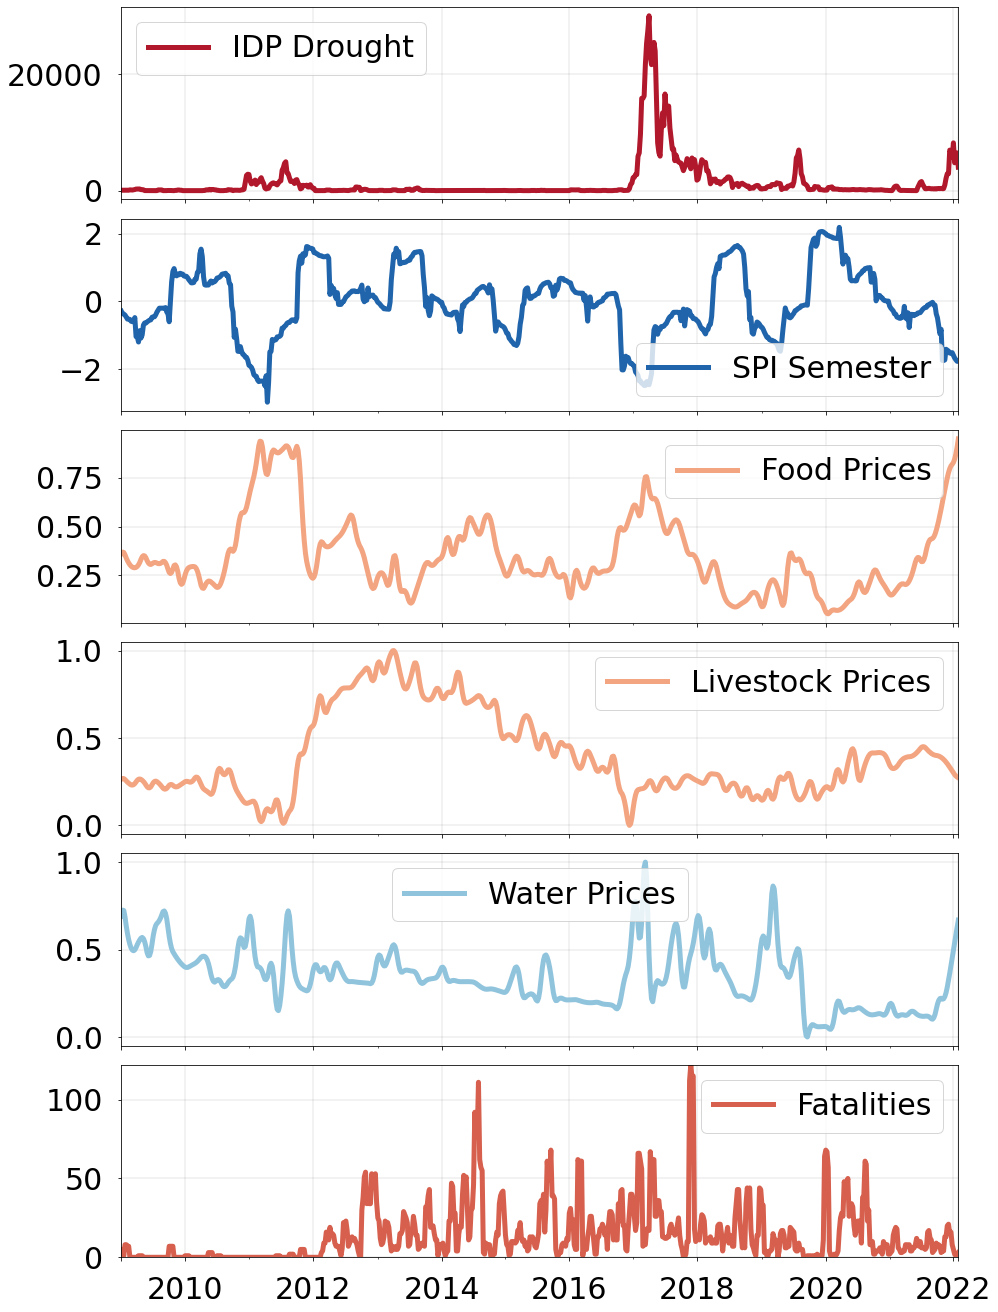

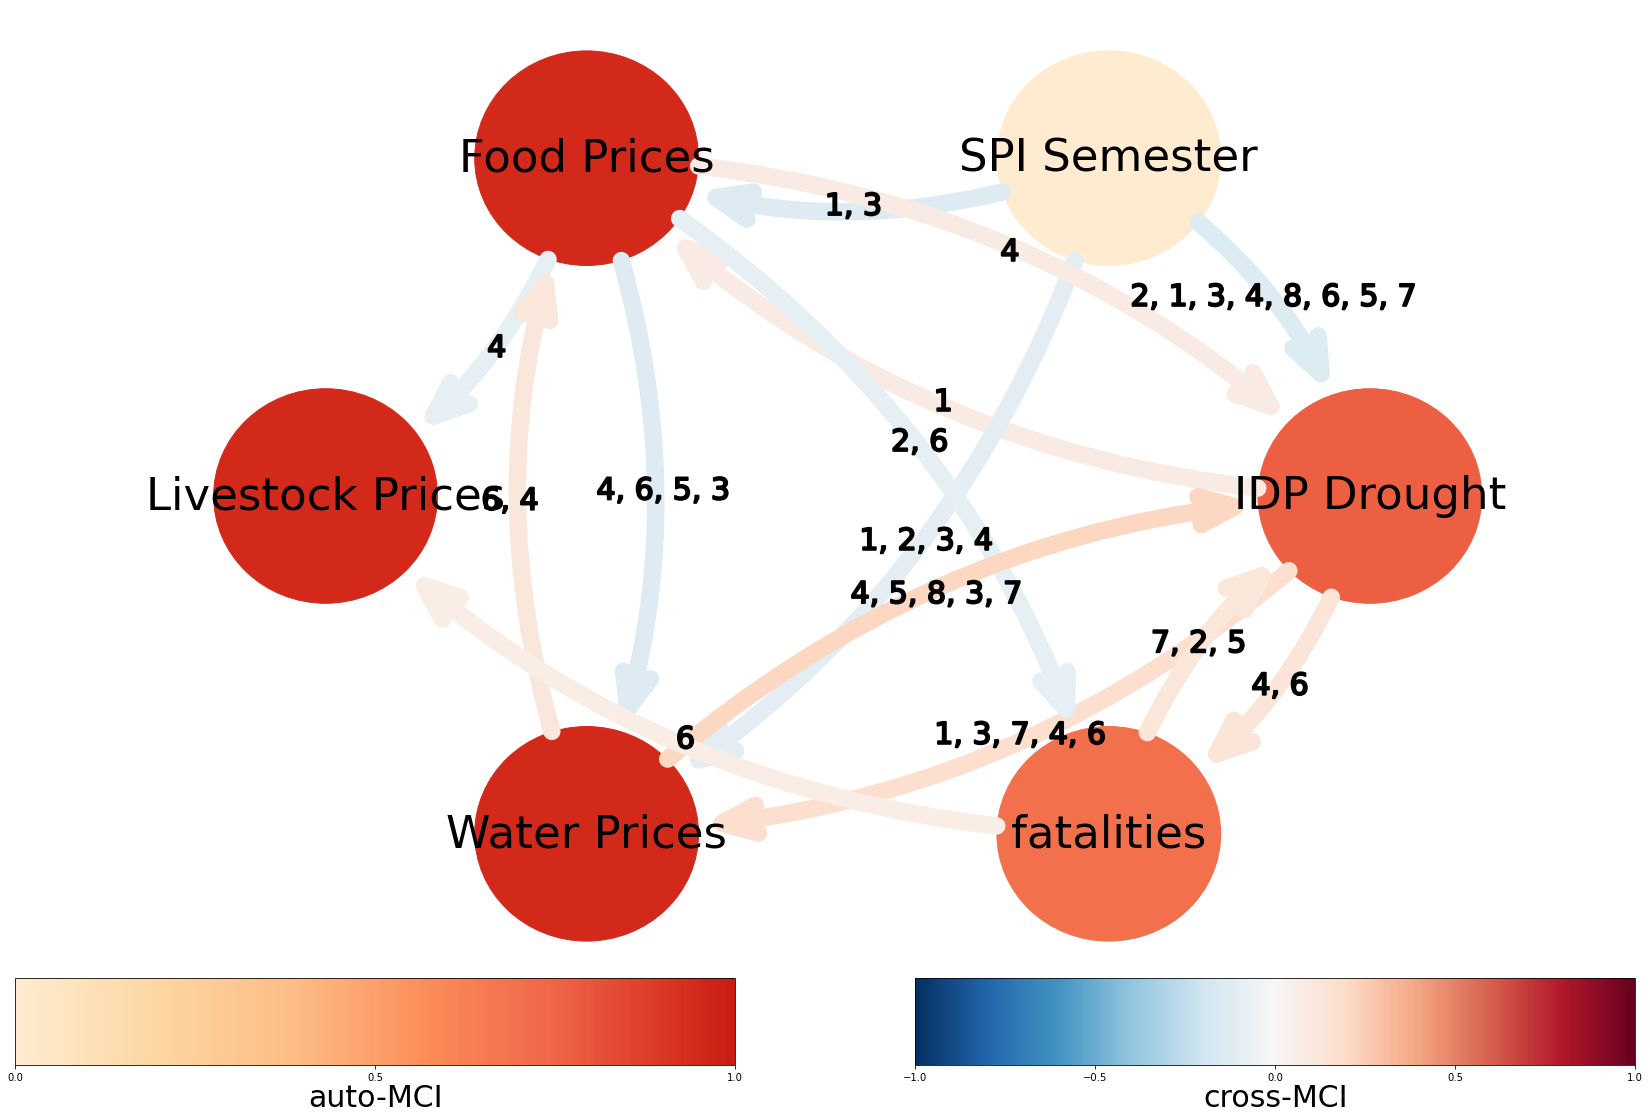

IDP Drought
Precipitation Semester
Food Prices
Livestock Prices
Water Prices
Fatalities


In [4]:
District_name = 'Baidoa'

DATA, results = create_graph(Somalia_IDP_Database, District_name, 
                       dates1 = '2009', 
                       dates2 = '2022', 
                       tau_max = 8)



# 3. Predictive Models

- Build Train/Test sets

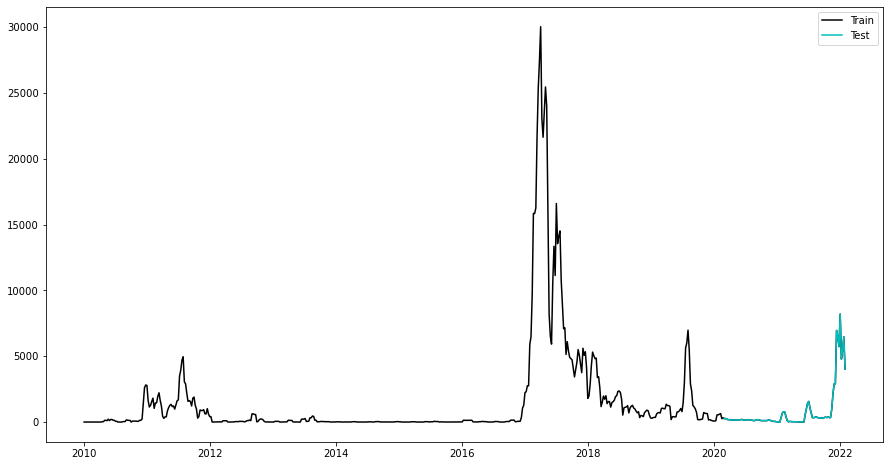

In [5]:
# Build causal feature dataframe from causal parents found in PCMCI

from aux_functions import build_win_feature, build_lag_feature
link_matrix = results['graph']

causal_lags = [[i for i, val in enumerate(link[0]) if val] for link in link_matrix][1:]
labels = DATA.columns
Causal_labels = labels[1:]
Causal_Data = pd.DataFrame()

for feat_idx in range(0,len(Causal_labels)):
    
    feature = Causal_labels[feat_idx]
    Causal_Data['IDP Drought'] = DATA['IDP Drought']
    
    if causal_lags[feat_idx]:
        
        lags = causal_lags[feat_idx]
        for lag in lags:
            name = feature + ' Lag' + str(lag)
            Causal_Data[name]= DATA[feature].shift(lag)

Causal_Data = Causal_Data.loc['2010':'2022'].dropna()



# Build dataframe with non-causal variables

lags = [1,2,3,4,5,6,7,8]

All_Causal_Data = DATA.iloc[:,1:]
All_Causal_Data = build_lag_feature(All_Causal_Data, lags).iloc[:,5:]

All_Causal_Data = pd.concat([DATA.iloc[:,0], All_Causal_Data], axis = 1)
All_Causal_Data = All_Causal_Data.loc['2010':'2022'].dropna() 


# Z-score and set trai/test set. We aim to predict the last wave

from scipy.stats import zscore
Causal_Data.iloc[:,1:] = Causal_Data.iloc[:,1:].apply(zscore)

# wave4 = Causal_Data.loc['Sep-2020':'Jan-2022']
wave4 = Causal_Data.loc['Mar-2020':'Jan-2022']
wave4_all = All_Causal_Data.loc['Mar-2020':'Jan-2022']

# Train-Test sets: Displacement waves

fig, axes = plt.subplots(1, 1, figsize=(15, 8),  sharex=True)

plt.plot(DATA['IDP Drought'].loc['2010':'Jan-2022'].index, DATA['IDP Drought'].loc['2010':'Jan-2022'], color = 'k')
plt.plot(wave4.index, wave4['IDP Drought'], color = 'c')
plt.legend(['Train', 'Test'])

# Define train-test sets for causal data:
wave4_train = Causal_Data.loc[~Causal_Data.index.isin(wave4.index)]
wave4_test = Causal_Data.loc[Causal_Data.index.isin(wave4.index)]

# Define train-test sets for non-causal data:
wave4_train_all = All_Causal_Data.loc[~All_Causal_Data.index.isin(wave4_all.index)]
wave4_test_all = All_Causal_Data.loc[All_Causal_Data.index.isin(wave4_all.index)]




# Poisson regression

- With causal and non-causal data




Mean squared error: 1569582.82
R2 0.42
0.75901241855465


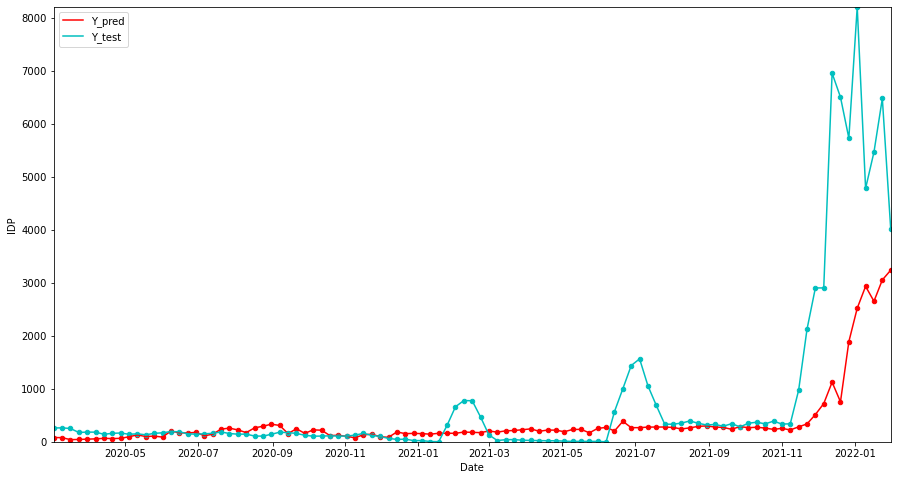

C:\Users\unknown\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Mean squared error: 2542544.89
R2 0.07
0.96603103213583


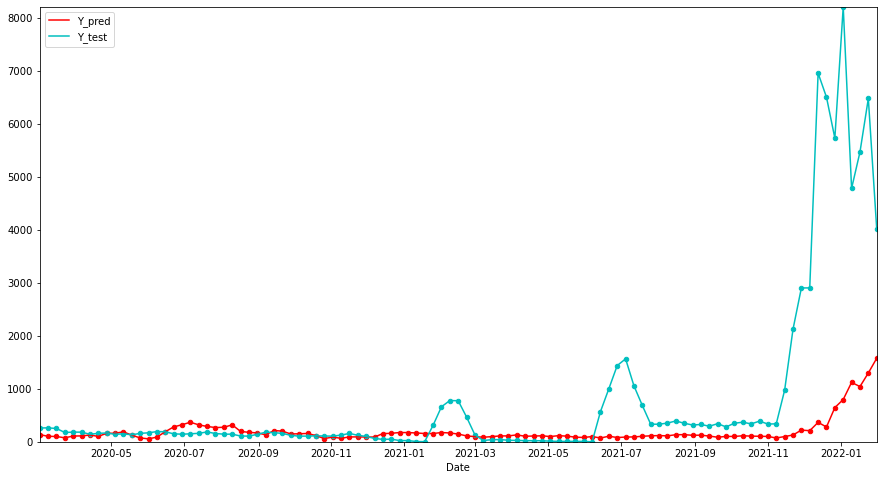

In [6]:
from sklearn.linear_model import TweedieRegressor
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


X_train, X_test, Y_train, Y_test = (wave4_train.iloc[:,1:], wave4_test.iloc[:,1:], wave4_train.iloc[:,0], wave4_test.iloc[:,0])


regr = TweedieRegressor(power=1, alpha=0, link='log', max_iter=10000000)

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
y_pred_tweed = regr.predict(X_test)

# y_pred = scale_y.inverse_transform(y_pred)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, y_pred_tweed))
# The coefficient of determination: 1 is perfect prediction
print("R2 %.2f"  % r2_score(Y_test, y_pred_tweed))

NRMSE = mean_squared_error(Y_test, y_pred_tweed , squared=False) / np.std(Y_test)
print(NRMSE)

fig, axes = plt.subplots(1, 1, figsize=(15, 8),  sharex=True)
plt.plot(Y_test.index, y_pred_tweed, label = 'Y_pred', color = 'r')
plt.plot(Y_test.index, Y_test, label = 'Y_test', color = 'c')
plt.scatter(Y_test.index, y_pred_tweed, color = 'r', s = 20)
plt.scatter(Y_test.index, Y_test, color = 'c', s = 20)
plt.xlabel('Date')
plt.ylabel('IDP')
# plt.title('RF predicción: NRMSE = '+ str(NRMSE))
plt.legend()

fig.subplots_adjust(wspace=0.15, hspace=0.2)
plt.margins(x=0, y = 0)
plt.show()

from sklearn.linear_model import TweedieRegressor
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler


X_train, X_test, Y_train, Y_test = (wave4_train_all.iloc[:,1:], wave4_test_all.iloc[:,1:], wave4_train_all.iloc[:,0], wave4_test_all.iloc[:,0])

# Create linear regression object
regr = TweedieRegressor(power=1, alpha=0, link='log', max_iter=10000000)

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
y_pred_tweed_all = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, y_pred_tweed_all))
# The coefficient of determination: 1 is perfect prediction
print("R2 %.2f"  % r2_score(Y_test, y_pred_tweed_all))

NRMSE = mean_squared_error(Y_test, y_pred_tweed_all , squared=False) / np.std(Y_test)
print(NRMSE)

fig, axes = plt.subplots(1, 1, figsize=(15, 8),  sharex=True)
plt.plot(Y_test.index, y_pred_tweed_all, label = 'Y_pred', color = 'r')
plt.plot(Y_test.index, Y_test, label = 'Y_test', color = 'c')
plt.scatter(Y_test.index, y_pred_tweed_all, color = 'r', s = 20)
plt.scatter(Y_test.index, Y_test, color = 'c', s = 20)
plt.xlabel('Date')
plt.legend()

fig.subplots_adjust(wspace=0.15, hspace=0.2)
plt.margins(x=0, y = 0)
plt.show()


### Random Forest

- With causal and non-causal data

0.7283175693968467
0.5174749681410529
0.7109250250800969
0.5316456412564715


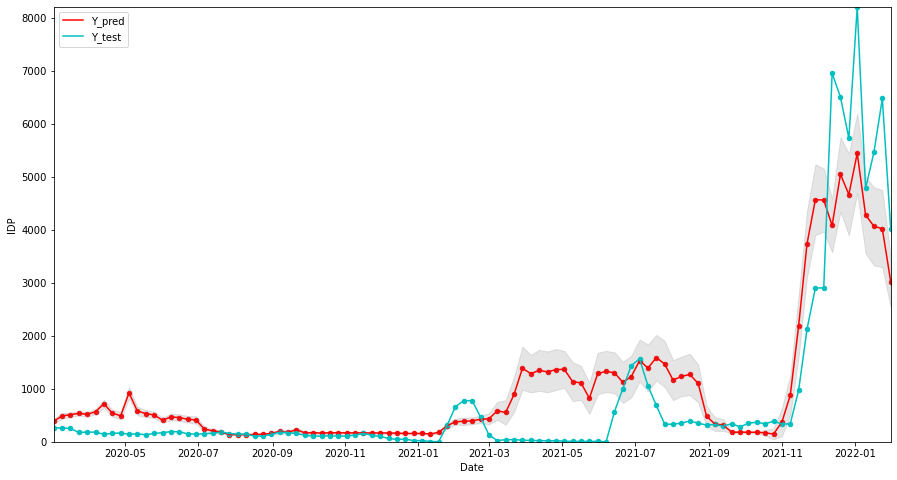

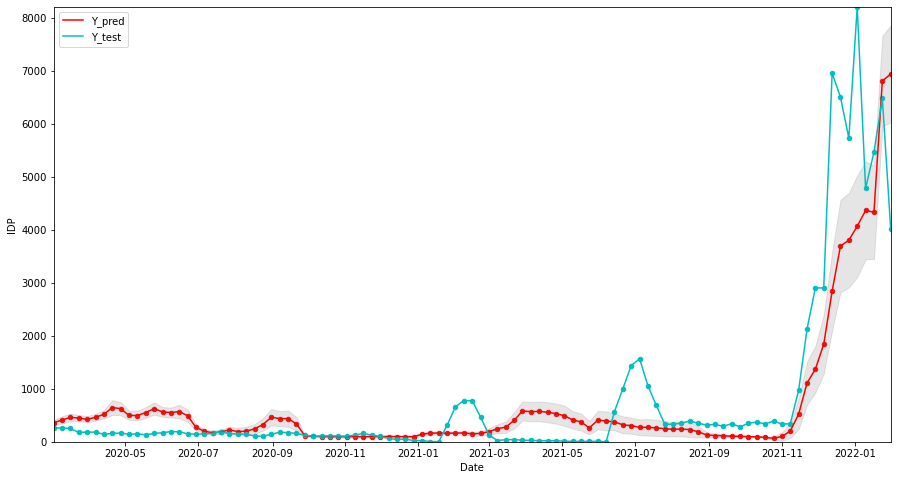

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# choose wave: 
R_tot = []
NRMSE_tot = []
Y_pred_tot = []

for i in range(0,100):
    
    rf_causal = RandomForestRegressor(n_estimators = 30, max_depth=32)
    
    X_train, X_test, Y_train, Y_test = (wave4_train.iloc[:,1:], wave4_test.iloc[:,1:], wave4_train.iloc[:,0], wave4_test.iloc[:,0])
    # Train the model on training data
    rf_causal.fit(X_train, Y_train)
    # Regress
    y_pred=rf_causal.predict(X_test)

    NRMSE = mean_squared_error(Y_test, y_pred , squared=False) / np.std(Y_test)
    model_score_R = r2_score(Y_test, y_pred, sample_weight=None, multioutput='uniform_average')
    
    R_tot.append(model_score_R)
    NRMSE_tot.append(NRMSE)
    Y_pred_tot.append(y_pred)

Y_pred_mean = np.mean(Y_pred_tot, axis = 0)
Y_pred_std = np.std(Y_pred_tot, axis = 0)

fig, axes = plt.subplots(1, 1, figsize=(15, 8),  sharex=True)
plt.plot(Y_test.index, Y_pred_mean, label = 'Y_pred', color = 'r')
plt.plot(Y_test.index, Y_test, label = 'Y_test', color = 'c')
plt.scatter(Y_test.index, Y_pred_mean, color = 'r', s = 20)
plt.fill_between(Y_test.index, Y_pred_mean - Y_pred_std, Y_pred_mean + Y_pred_std, color='gray', alpha=0.2)
plt.scatter(Y_test.index, Y_test, color = 'c', s = 20)
plt.xlabel('Date')
plt.ylabel('IDP')
# plt.title('RF predicción: NRMSE = '+ str(NRMSE))
plt.legend()

fig.subplots_adjust(wspace=0.15, hspace=0.2)
plt.margins(x=0, y = 0)
print(np.mean(R_tot))
print(np.mean(NRMSE_tot))

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error

# choose wave: 
R_tot = []
NRMSE_tot = []
Y_pred_tot = []

for i in range(0,100):

    rf_all = RandomForestRegressor(n_estimators = 30, max_depth=32)
        
    X_train, X_test, Y_train, Y_test = (wave4_train_all.iloc[:,1:], wave4_test_all.iloc[:,1:], wave4_train_all.iloc[:,0], wave4_test_all.iloc[:,0])

    # Train the model on training data
    rf_all.fit(X_train, Y_train)
    # Regress
    y_pred_all=rf_all.predict(X_test)

    # NRMSE = (np.abs(Y_test - y_pred_all).mean()/Y_test.std
    NRMSE = mean_squared_error(Y_test, y_pred_all , squared=False) / np.std(Y_test)
    model_score_R = r2_score(Y_test, y_pred_all, sample_weight=None, multioutput='uniform_average')
    
    R_tot.append(model_score_R)
    NRMSE_tot.append(NRMSE)
    Y_pred_tot.append(y_pred_all)

Y_pred_mean_all = np.mean(Y_pred_tot, axis = 0)
Y_pred_std_all = np.std(Y_pred_tot, axis = 0)


fig, axes = plt.subplots(1, 1, figsize=(15, 8),  sharex=True)
plt.plot(Y_test.index, Y_pred_mean_all, label = 'Y_pred', color = 'r')
plt.plot(Y_test.index, Y_test, label = 'Y_test', color = 'c')
plt.scatter(Y_test.index, Y_pred_mean_all, color = 'r', s = 20)
plt.fill_between(Y_test.index, Y_pred_mean_all - Y_pred_std_all, Y_pred_mean_all + Y_pred_std_all, color='gray', alpha=0.2)
plt.scatter(Y_test.index, Y_test, color = 'c', s = 20)
plt.xlabel('Date')
plt.ylabel('IDP')
# plt.title('RF predicción: NRMSE = '+ str(NRMSE))
plt.legend()

fig.subplots_adjust(wspace=0.15, hspace=0.2)
plt.margins(x=0, y = 0)
print(np.mean(R_tot))
print(np.mean(NRMSE_tot))




# Prediction Comparison:

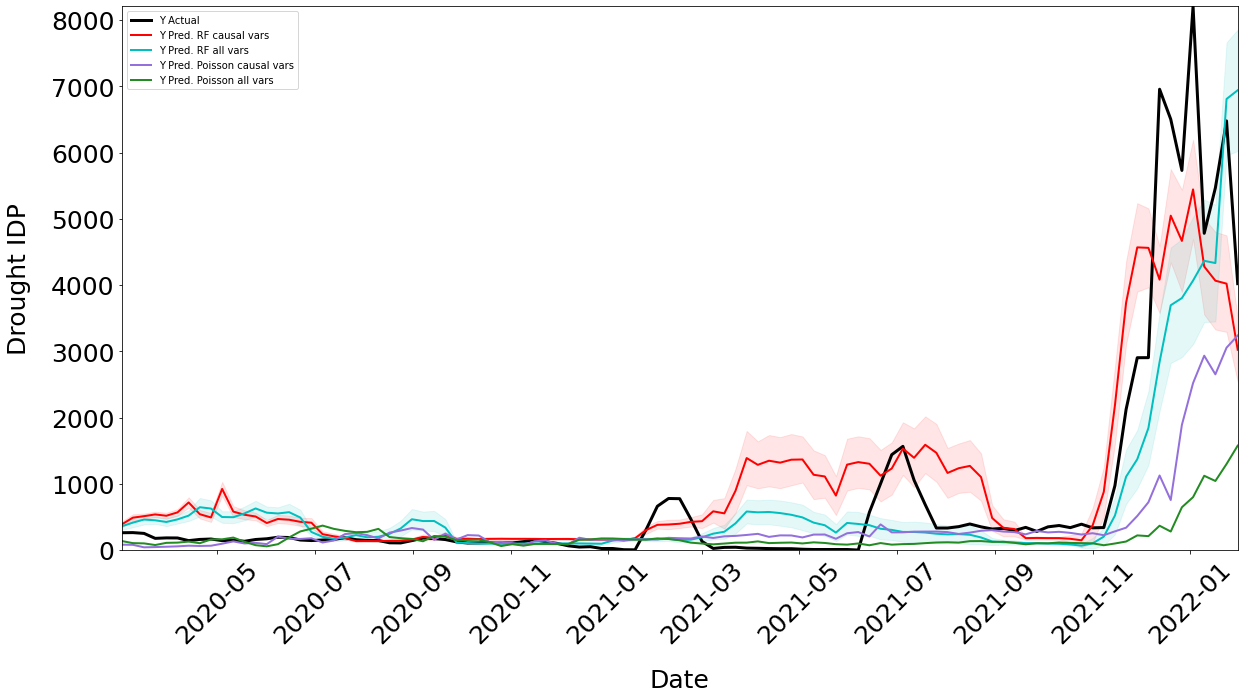

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10),  sharex=True)

# True data

plt.plot(Y_test.index, Y_test, label = 'Y Actual', color = 'k', lw = 3)

# RF causal
plt.plot(Y_test.index, Y_pred_mean, label = 'Y Pred. RF causal vars', color = 'r', lw = 2)
plt.fill_between(Y_test.index, Y_pred_mean - Y_pred_std, Y_pred_mean + Y_pred_std, color='r', alpha=0.1)

# RF all
plt.plot(Y_test.index, Y_pred_mean_all, label = 'Y Pred. RF all vars', color = 'c', lw = 2)
plt.fill_between(Y_test.index, Y_pred_mean_all - Y_pred_std_all, Y_pred_mean_all + Y_pred_std_all, color='c', alpha=0.1)

plt.xlabel('Date',labelpad = 20, fontsize = 25)
plt.ylabel('Drought IDP', labelpad = 20, fontsize = 25)
plt.xticks(fontsize=25, rotation  = 45)
plt.yticks(fontsize=25)
plt.legend()


# poisson causal
plt.plot(Y_test.index, y_pred_tweed, label = 'Y Pred. Poisson causal vars', color = 'mediumpurple', lw = 2)

# RF all
plt.plot(Y_test.index, y_pred_tweed_all, label = 'Y Pred. Poisson all vars', color = 'forestgreen', lw = 2)

plt.xlabel('Date',labelpad = 20, fontsize = 25)
plt.ylabel('Drought IDP', labelpad = 20, fontsize = 25)
plt.xticks(fontsize=25, rotation  = 45)
plt.yticks(fontsize=25)

plt.legend()

plt.margins(x=0, y = 0)


# Explanations:

In [9]:
_, X_test, _, Y_test = (wave4_train.iloc[:,1:], wave4_test.iloc[:,1:], wave4_train.iloc[:,0], wave4_test.iloc[:,0])

In [10]:
explainer = RegressionExplainer(rf_causal, X_test, Y_test)

Changing class type to RandomForestRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [11]:
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://10.20.58.107:8050
Dash is running on http:/

 * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)
10.20.58.107 - - [23/Jun/2023 10:52:41] "GET / HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:41] "GET /assets/bootstrap.min.css?m=1685962540.035225 HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:41] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_10_2m1685961763.12.1.min.js HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:41] "GET /_dash-component-suites/dash/deps/react@16.v2_10_2m1685961763.14.0.min.js HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:41] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_10_2m1685961763.14.0.min.js HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:41] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_10_2m1685961763.8.1.min.js HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:41] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v1_4_1m1685961766.min.js HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:41] "GET /_d

10.20.58.107 - - [23/Jun/2023 10:52:45] "POST /_dash-update-component HTTP/1.1" 204 -
10.20.58.107 - - [23/Jun/2023 10:52:45] "POST /_dash-update-component HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:45] "POST /_dash-update-component HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:45] "POST /_dash-update-component HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:52:45] "POST /_dash-update-component HTTP/1.1" 204 -
10.20.58.107 - - [23/Jun/2023 10:52:45] "POST /_dash-update-component HTTP/1.1" 204 -
10.20.58.107 - - [23/Jun/2023 10:52:46] "POST /_dash-update-component HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:53:19] "POST /_dash-update-component HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 10:53:21] "POST /_dash-update-component HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 11:04:07] "POST /_dash-update-component HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 11:04:17] "POST /_dash-update-component HTTP/1.1" 200 -
10.20.58.107 - - [23/Jun/2023 11:04:21] "POST /_dash-u